First, we will need to investigate the columns to understand what they are and implement some domain knowledge to get a better sense of what's going on with the data.
id:
Lat_Dec:
Lon_Dec:
NO2uM:
NO3uM:
NH3uM:
R_TEMP:
R_Depth:
R_Sal: 
R_DYNHT: 
R_Nuts:
R_Oxy_micromol.Kg:
Unnamed:
PO4uM:
SiO3uM:
TA1.x:
Salinity1:
Temperature_degC:
DIC: outcome variable (dissolved inorganic carbon)


In [165]:
# Import libraries
import numpy as np 
import pandas as pd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [135]:
# Read in data
data = pd.read_csv("data/training.csv")

# Remove the NA values
data = data.drop('Unnamed: 12', axis=1)

# Rename columns to match test data
data = data.rename(columns={'TA1.x': 'TA1'})

# Get on test data
test_data = pd.read_csv('data/test.csv')


In [158]:
# Split the data into features and target variable
X = data.drop(['DIC', 'id'], axis=1)
y = data['DIC']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [89]:
# Random Forest
'''
# Create and train the random forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

# Make predictions using the trained model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)  # Assuming X_imputed and y are the imputed training data and target variable
predictions = rf_model.predict(test_data)

# Create a submission DataFrame
submission_df = pd.DataFrame({'id': test_data['id'], 'DIC': predictions})

# Save the submission DataFrame to a CSV file
# submission_df.to_csv('submission.csv', index=False)
'''

Mean Squared Error: 28.649264310055422
Mean Absolute Error: 3.147116996319242
R-squared: 0.9978568099148537


In [172]:
# XGBoost

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2],               
    'lambda': [0, 1, 2]                   
}

# Create the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error',
                           verbose = 1)
grid_search.fit(X_train, y_train)
x
# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


KeyboardInterrupt: 

In [131]:
# Create the XGBoost model with the best features
'''
top_features = ['SiO3uM', 'PO4uM', 'R_Oxy_micromol.Kg', 'TA1', 'R_Sal', 'NO3uM', 'Salinity1']

X_top_features = X[top_features]

X_train_top, X_test_top, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

xgb_top_model = xgb.XGBRegressor(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42
)

# Train the model on the training set with only the top features
xgb_top_model.fit(X_train_top, y_train)

# Evaluate the model on the test set with only the top features
y_pred_top = xgb_top_model.predict(X_test_top)
mse_top = mean_squared_error(y_test, y_pred_top)
mae_top = mean_absolute_error(y_test, y_pred_top)
r2_top = r2_score(y_test, y_pred_top)

# Print out the performance
print(f"Mean Squared Error with top features: {mse_top}")
print(f"Mean Absolute Error with top features: {mae_top}")
print(f"R-squared with top features: {r2_top}")
'''

Mean Squared Error with top features: 31.25689526698745
Mean Absolute Error with top features: 3.1617093636436837
R-squared with top features: 0.9976617386295273


In [169]:
# Convert the dataset into a data structure that XGBoost supports
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'learning_rate': 0.05,
    'n_estimators': 700,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'objective': 'reg:squarederror',  # Use 'reg:linear' for older versions of XGBoost
    'random_state': 42
}

# Specify the number of cross-validation folds and the metrics for evaluation
cv_results = xgb.cv(
    dtrain=dtrain,
    params=params,
    nfold=5,
    num_boost_round=500,  # The number of boosting rounds or trees to build
    early_stopping_rounds=50,  # Stop if the metric does not improve in these many rounds
    metrics="rmse",  # Root Mean Squared Error
    as_pandas=True,
    seed=13
)

# Display the CV results
print(cv_results)

# You can also find the best number of trees from cv_results
best_num_boost_round = len(cv_results)

# Train the model with the best number of boosting rounds
final_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round
)

# Predict on the test set
predictions = final_model.predict(dtest)

# Evaluate the final model (you can use any evaluation metric that suits your problem)
final_mse_cv = cv_results['test-rmse-mean'].iloc[-1] # Last row's RMSE squared to get MSE
print("Mean Squared Error:", final_mse_cv)

# Ensure test_data_features is prepared with the same features as those used during the model training
test_data_features = test_data[X.columns]  # Assuming 'X.columns' contains the correct features

# Create a DMatrix for the actual test data (test_data_features)
dtest_actual = xgb.DMatrix(test_data_features)

# Use the trained model to make predictions on the actual test dataset
predictions_actual_test_data = final_model.predict(dtest_actual)

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_data['id'],  # Assuming test_data contains an 'id' column
    'DIC': predictions_actual_test_data
})

# Save the submission DataFrame to a CSV file
submission_csv_path = 'submission3.csv' # Change the file name as needed
submission_df.to_csv(submission_csv_path, index=False)

/Users/maxwellpatterson/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [22:16:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         107.087405        0.474315      107.428583       2.046681
1         101.849018        0.446236      102.182698       1.926607
2          96.877947        0.421051       97.209284       1.841175
3          92.143475        0.400837       92.455887       1.741683
4          87.652024        0.376662       87.969927       1.647737
..               ...             ...             ...            ...
302         0.132107        0.012483        6.071830       0.386631
303         0.130810        0.012216        6.071621       0.386526
304         0.129240        0.012069        6.071770       0.386477
305         0.128022        0.011772        6.071712       0.386423
306         0.126880        0.011871        6.071557       0.386408

[307 rows x 4 columns]


/Users/maxwellpatterson/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [22:16:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: 6.071556739563375


In [142]:
# Prepare the training data
X = data.drop(['DIC', 'id'], axis=1)  # Features for training
y = data['DIC']  # Target variable

# Prepare the test data (similar preprocessing as the training data, excluding target variable)
test_data_features = test_data[X.columns]  # Ensure this matches the features used in training

# Convert the training data into DMatrix format for XGBoost
dtrain_full = xgb.DMatrix(X, label=y)

# Define your model parameters here
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'n_estimators': 700,
    'random_state': 42
}

# Number of boosting rounds
num_boost_round = 1000  # Adjust based on model performance and early stopping

# Train the model on the entire training dataset
final_model = xgb.train(params, dtrain_full, num_boost_round)

# Convert the test dataset into DMatrix format
dtest = xgb.DMatrix(test_data_features)

# Use the trained model to make predictions on the test dataset
predictions = final_model.predict(dtest)

# Create a submission DataFrame
submission_df = pd.DataFrame({'id': test_data['id'], 'DIC': predictions})

# Save the submission DataFrame to a CSV file
submission_csv_path = 'submissions.csv'
submission_df.to_csv(submission_csv_path, index=False)

/Users/maxwellpatterson/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [21:37:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


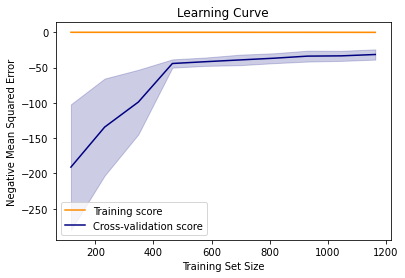

In [145]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', **best_params), # Assuming best_params from your tuning
    X=X, y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training score", color="darkorange")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="darkorange", alpha=0.2)

plt.plot(train_sizes, test_mean, label="Cross-validation score", color="navy")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="navy", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Negative Mean Squared Error")
plt.legend(loc="best")
plt.show()


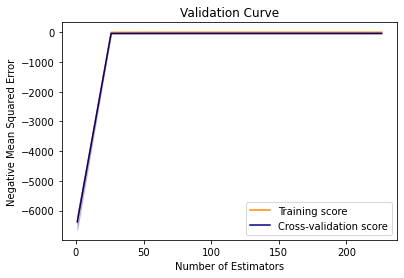

In [146]:
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 250, 25)  # Example: n_estimators for XGBoost
train_scores, test_scores = validation_curve(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    X=X, y=y,
    param_name='n_estimators',
    param_range=param_range,
    cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, label="Training score", color="darkorange")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="darkorange", alpha=0.2)

plt.plot(param_range, test_mean, label="Cross-validation score", color="navy")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="navy", alpha=0.2)

plt.title("Validation Curve")
plt.xlabel("Number of Estimators")
plt.ylabel("Negative Mean Squared Error")
plt.legend(loc="best")
plt.show()


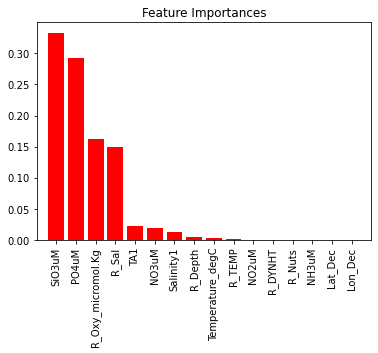

In [147]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
xgb_model.fit(X_train, y_train)

feature_importances = xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [157]:
test_data.columns

Index(['id', 'Lat_Dec', 'Lon_Dec', 'NO2uM', 'NO3uM', 'NH3uM', 'R_TEMP',
       'R_Depth', 'R_Sal', 'R_DYNHT', 'R_Nuts', 'R_Oxy_micromol.Kg', 'PO4uM',
       'SiO3uM', 'TA1', 'Salinity1', 'Temperature_degC'],
      dtype='object')

In [166]:
xgb_model = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}
